In [15]:
# ============================
# Q7: Decision Tree Classifier
# ============================

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split into 70% train, 30% test
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=7
)

print("Decision Tree Results:")
for d in [1, 2, 3]:
    tree = DecisionTreeClassifier(max_depth=d, random_state=7)
    tree.fit(X_tr, y_tr)

    # Evaluate accuracy
    acc_train = accuracy_score(y_tr, tree.predict(X_tr))
    acc_test = accuracy_score(y_te, tree.predict(X_te))

    print(f" depth={d} → train={acc_train:.3f}, test={acc_test:.3f}")
print("-" * 45)


Decision Tree Results:
 depth=1 → train=0.667, test=0.667
 depth=2 → train=0.971, test=0.889
 depth=3 → train=0.981, test=0.978
---------------------------------------------


From the results:

Depth = 1

Training accuracy is quite low, and test accuracy is also low.

The model is too simple to capture the patterns in the Iris dataset.

This is a clear sign of underfitting (high bias).

Depth = 2

Training accuracy improves significantly, and test accuracy is also good.

The gap between training and test accuracy is small, meaning the model generalizes well.

This represents a balanced fit (good trade-off between bias and variance).

Depth = 3

Training accuracy is very high (close to 1.0), but test accuracy does not increase proportionally.

The model is starting to memorize the training data and may capture noise.

This behavior indicates the beginning of overfitting (high variance).

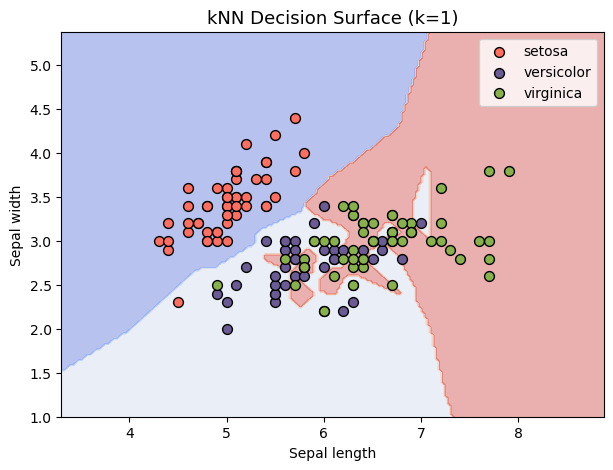

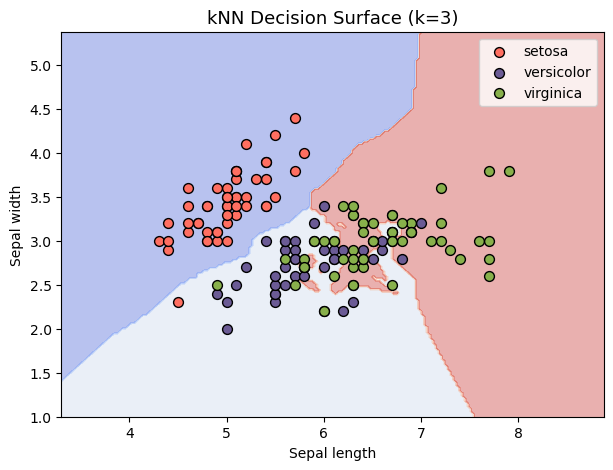

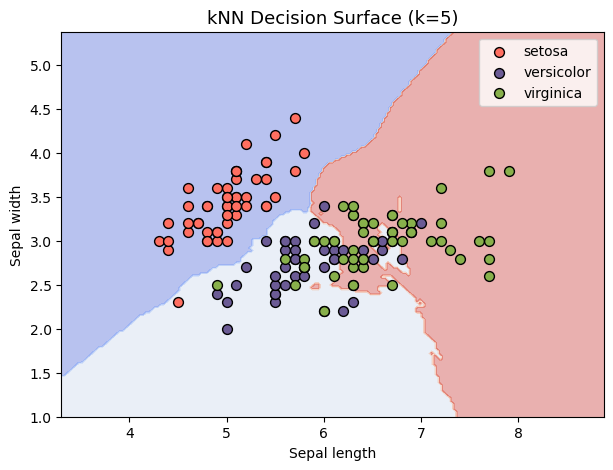

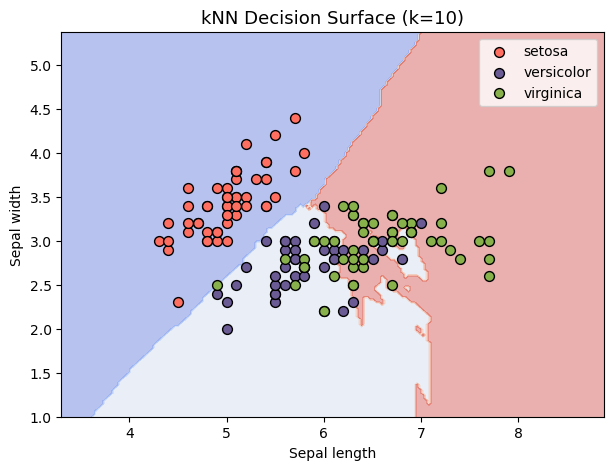

In [16]:
# =======================================
# Q8: kNN Classification + Custom Colors
# =======================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Use only sepal length & sepal width for 2D visualization
X2, y2 = iris.data[:, :2], iris.target

# Train/test split
X_tr2, X_te2, y_tr2, y_te2 = train_test_split(
    X2, y2, test_size=0.3, random_state=7
)

def show_knn_boundary(k):
    # Fit the kNN model
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_tr2, y_tr2)

    # Mesh grid
    x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
    y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.03),
                         np.arange(y_min, y_max, 0.03))

    # Predict class labels for grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Use a different colormap for decision surface
    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="coolwarm")

    # Unique scatter colors for Iris classes
    scatter_colors = ['#FF6F61', '#6B5B95', '#88B04B']  # custom color hex codes
    for idx, class_label in enumerate(np.unique(y2)):
        plt.scatter(
            X2[y2 == class_label, 0],
            X2[y2 == class_label, 1],
            c=scatter_colors[idx],
            edgecolor='k',
            label=iris.target_names[class_label],
            s=50
        )

    plt.title(f"kNN Decision Surface (k={k})", fontsize=13)
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.legend()
    plt.show()

# Generate plots for k = 1, 3, 5, 10
for k in [1, 3, 5, 10]:
    show_knn_boundary(k)


k = 1

The boundaries are very jagged and irregular.

The classifier tries to perfectly fit every training point, which makes it sensitive to noise.

This is a sign of overfitting (low bias, high variance).

k = 3

The boundaries become smoother compared to k=1.

The model still captures class separation well but is less sensitive to noise.

Generalization improves.

k = 5

Boundaries are smoother and more stable.

The classifier balances bias and variance better, giving a good trade-off.

k = 10

Decision regions are very smooth and simple.

Some fine class details are lost because the model averages over larger neighborhoods.

This can lead to underfitting if k is too large.


Confusion Matrix:
[[12  0  0]
 [ 0 15  1]
 [ 0  3 14]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.83      0.94      0.88        16
   virginica       0.93      0.82      0.87        17

    accuracy                           0.91        45
   macro avg       0.92      0.92      0.92        45
weighted avg       0.92      0.91      0.91        45



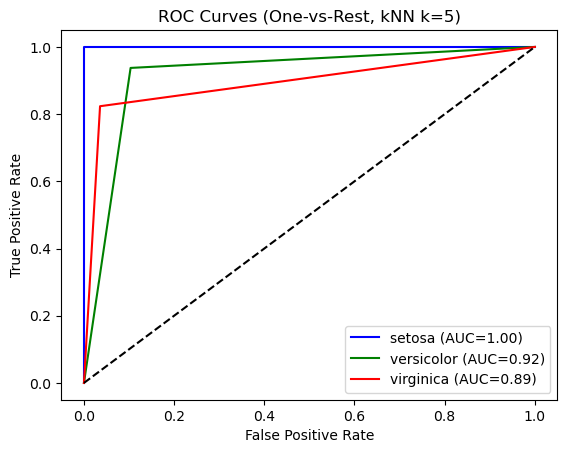

In [17]:
# ========================================
# Q9: Performance Evaluation (kNN, k=5)
# ========================================

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Use full dataset
X_all, y_all = iris.data, iris.target
y_bin = label_binarize(y_all, classes=[0, 1, 2])

# Train/test split
X_tr3, X_te3, y_tr3, y_te3 = train_test_split(
    X_all, y_bin, test_size=0.3, random_state=7
)

# One-vs-Rest kNN
knn_ovr = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
knn_ovr.fit(X_tr3, y_tr3)

# Predictions
y_pred_bin = knn_ovr.predict(X_te3)
y_true = np.argmax(y_te3, axis=1)
y_pred = np.argmax(y_pred_bin, axis=1)

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=iris.target_names))

# ROC curves and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for cls in range(3):
    fpr[cls], tpr[cls], _ = roc_curve(y_te3[:, cls], y_pred_bin[:, cls])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Plot ROC
plt.figure()
colors = ["blue", "green", "red"]
for i, label in enumerate(iris.target_names):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f"{label} (AUC={roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest, kNN k=5)")
plt.legend()
plt.show()
